In [16]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import gzip
sys.path.insert(0, '../src/')
import helpers as h
%matplotlib inline

In [17]:
n_samples = 100
n_samples_fold = (n_samples+1)//2
r_slim = 1e-8
mu = 1e-7
N = 1e3
L = int(1e8)
w = int(1e3)
lim = L//(10*w)
dist = w*np.arange(lim + 1)

Import SLiM output

In [18]:
fn_pattern = '../simulations/slim/{}_fsel-0.0_corrmerged.txt.gz'

In [19]:
fn_slim = fn_pattern.format('sweeps')
data_slim = h.readcorr_normed(fn_slim, n_samples)
pi_slim, sfs_slim, pi_corr_slim, lolo_corr_slim, lohi_corr_slim, hihi_corr_slim = data_slim

In [20]:
d_c = (2*mu) / (r_slim*pi_slim)
print(pi_slim)
print(d_c)

0.000199904388465
100047.828633


Import msprime output

In [21]:
r_list = np.insert(np.logspace(-1,3,13), 0, 0.0)[:-3]
file_list = ['../simulations/jsfs_a-2.0_r-{}.txt'.format(r) for r in r_list]
n_files = len(file_list)
data_mspr = h.import_msprime_corr(file_list, n_samples)
pi_mspr, sfs_mspr, jsfs_mspr, pi_corr_mspr, lolo_corr_mspr, lohi_corr_mspr, hihi_corr_mspr = data_mspr

Compare $\pi$ and the marginal SFS

In [7]:
print(pi_slim)
print(pi_slim/(mu*N))
print(pi_mspr)
print(np.mean(pi_mspr))

0.000199904388465
1.99904388465
[ 1.99984105  1.99976596  1.9975245   2.00275723  2.00212653  2.0016864
  2.00095063  2.00158607  1.99895572  2.00272737  2.00252323]
2.00094951742


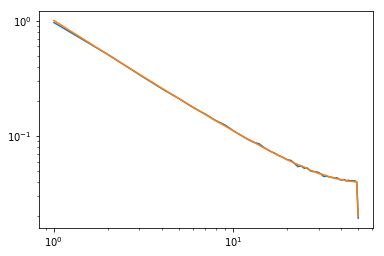

In [8]:
plt.loglog(np.arange(1,n_samples//2+1), sfs_slim/pi_slim)
plt.loglog(np.arange(1,n_samples//2+1), np.mean(sfs_mspr, axis=0)/np.mean(pi_mspr))

# $\pi$ correlations

Compare the correlation function of $\pi$.

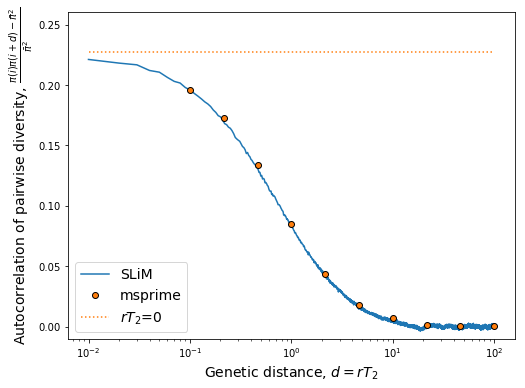

In [9]:
fs=14
plt.figure(figsize=(8, 6))
plt.semilogx(dist/d_c, pi_corr_slim, color='C0', label='SLiM')
#plt.semilogx(dist/d_c, pi_corr_mssl/pi_mssl**2, color='C1', label='msprime_muts')
plt.semilogx(r_list*pi_mspr/2, pi_corr_mspr, 'o', mfc='C1', mec='k', label='msprime')
plt.ylim([-0.01,0.26])
plt.hlines(pi_corr_mspr[0], 0.01, 100, color='C1', linestyle='dotted', label='$rT_2$=0')

plt.xlabel('Genetic distance, $d=rT_2$', fontsize=fs)
plt.ylabel(r'Autocorrelation of pairwise diversity, $\frac{\pi(i)\pi(i+d)-\bar{\pi}^2}{\bar{\pi}^2}$', fontsize=fs)
plt.legend(loc=3, fontsize=fs)
#plt.savefig('pi_autoccorrelation.pdf')

# SFS correlations

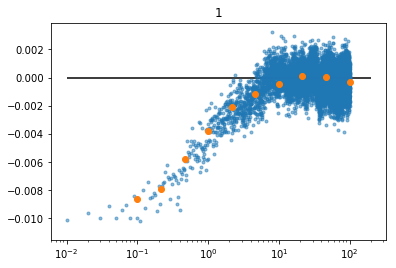

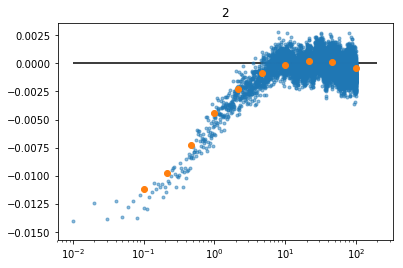

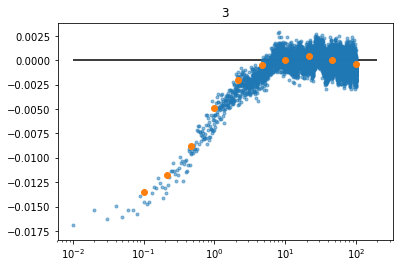

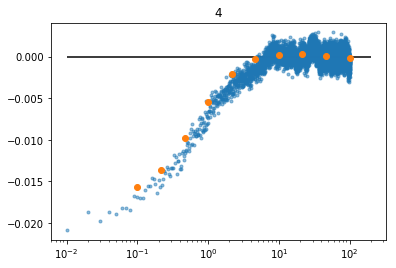

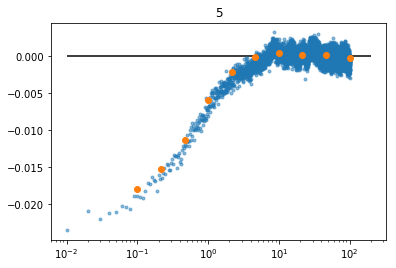

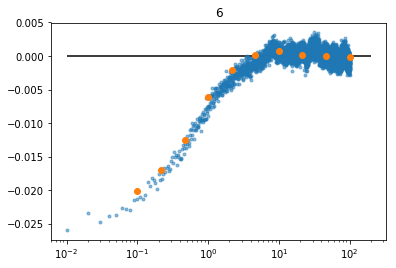

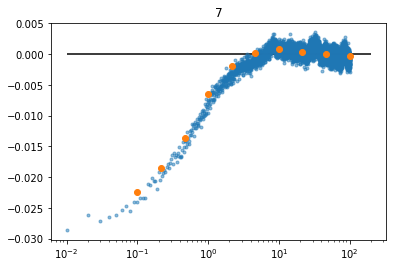

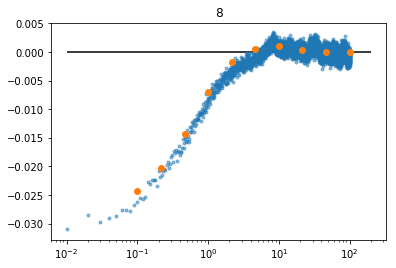

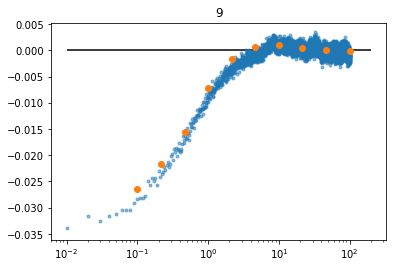

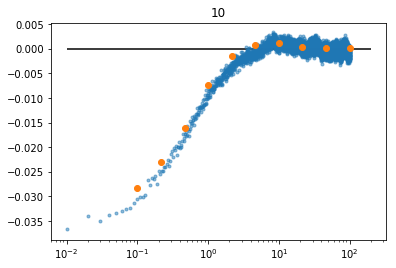

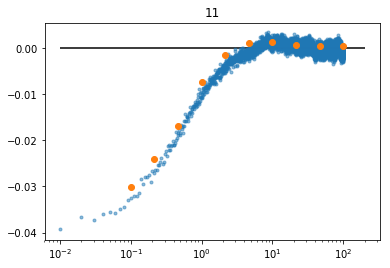

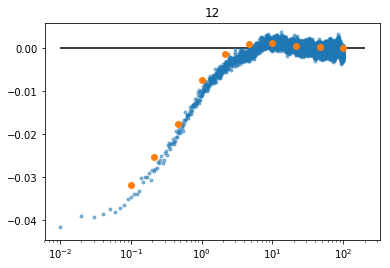

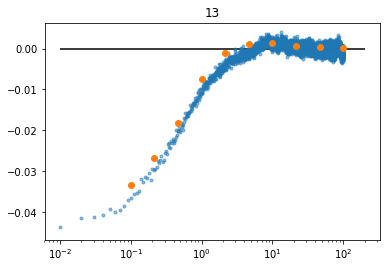

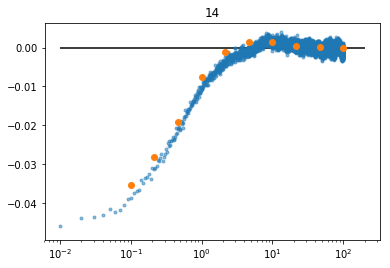

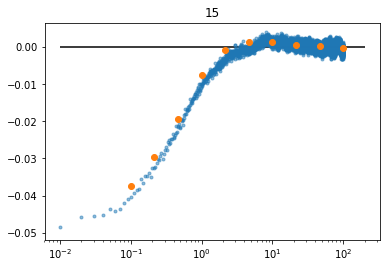

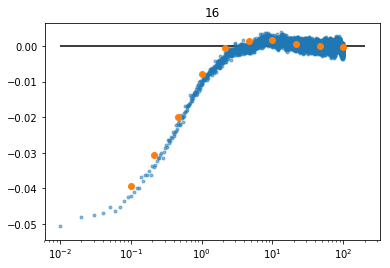

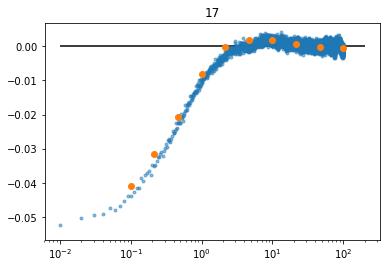

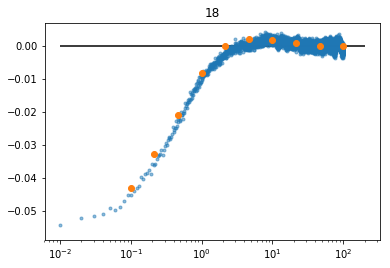

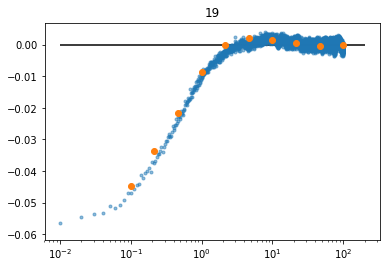

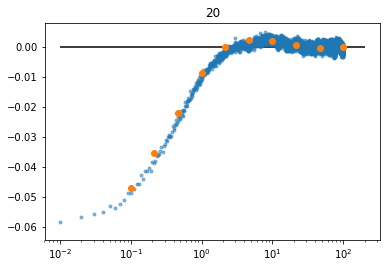

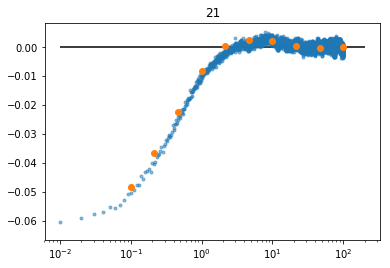

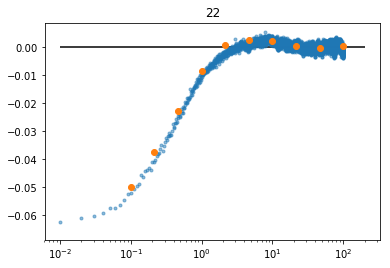

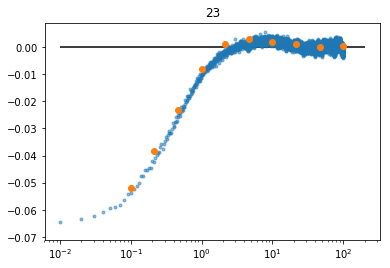

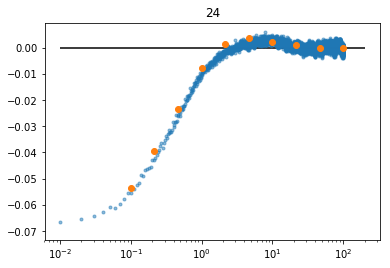

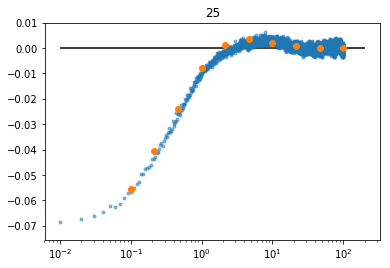

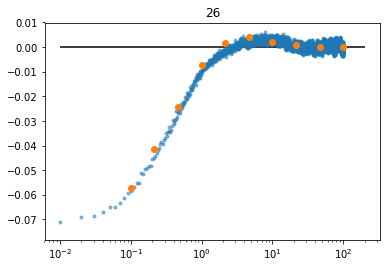

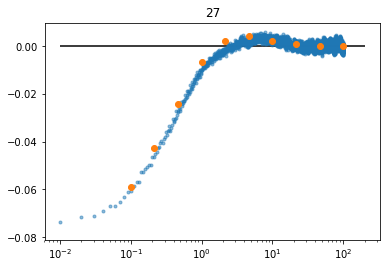

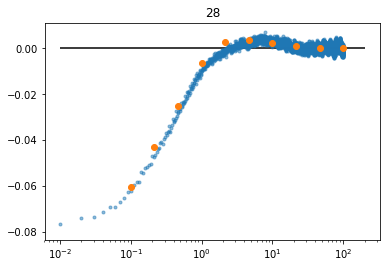

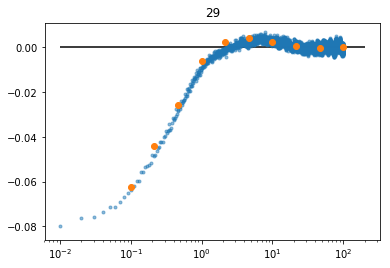

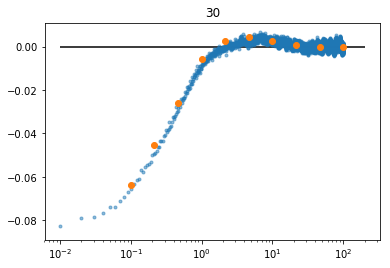

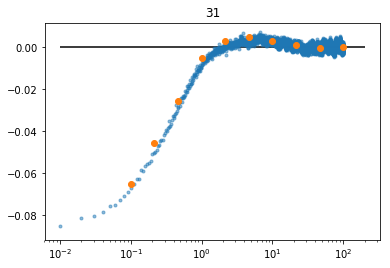

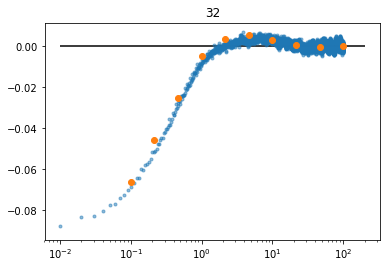

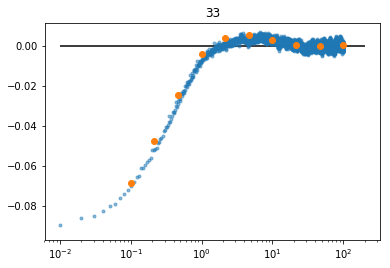

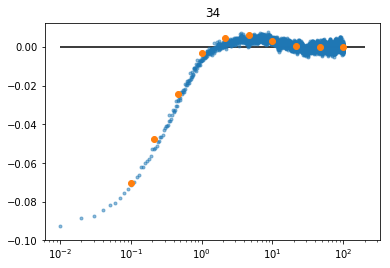

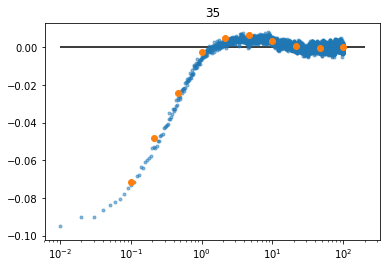

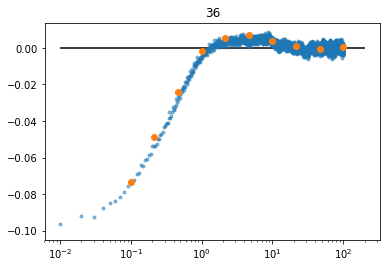

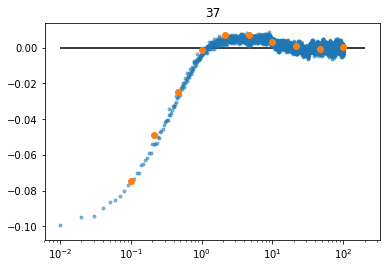

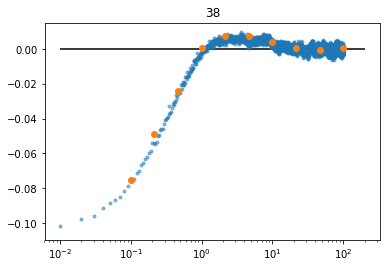

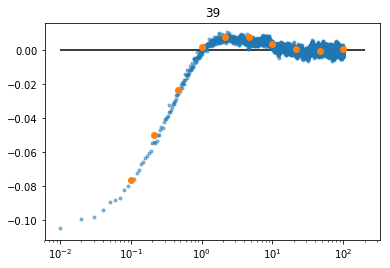

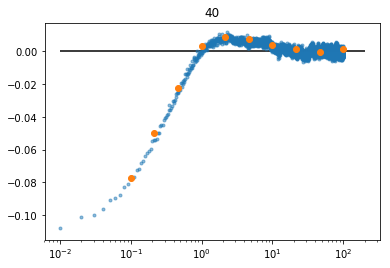

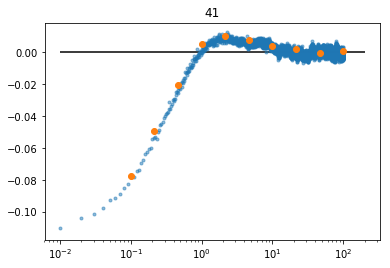

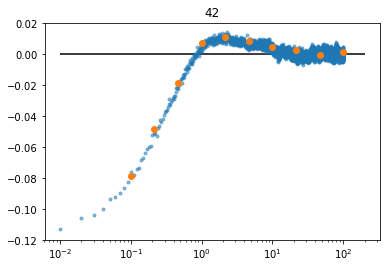

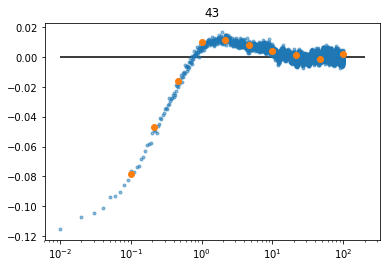

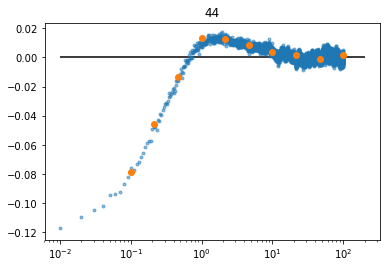

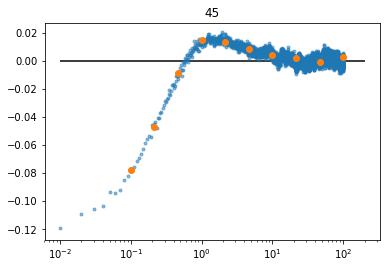

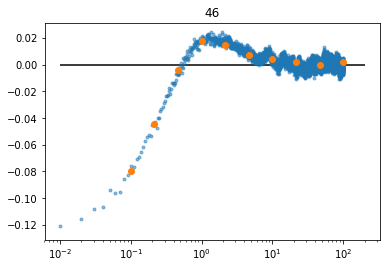

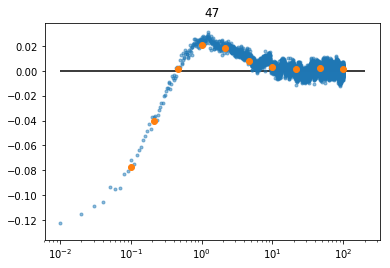

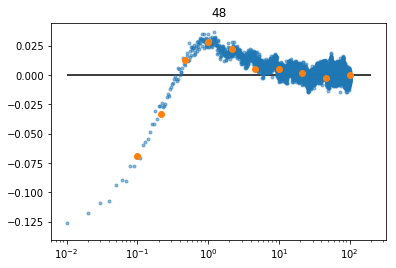

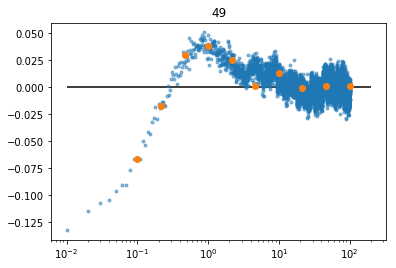

In [10]:
for cutoff in range(1,n_samples//2):
    i = cutoff - 1
    plt.semilogx(dist/d_c, lohi_corr_slim[i], '.', alpha=0.5)
    plt.semilogx(r_list*pi_mspr/2, lohi_corr_mspr[:,i], 'o')
    plt.hlines(0, 1e-2, 2e2)
    plt.title(cutoff)
    plt.show()

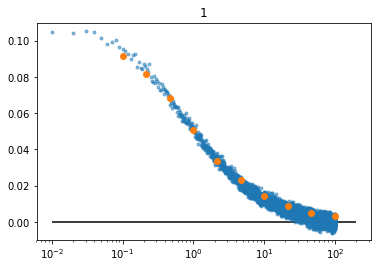

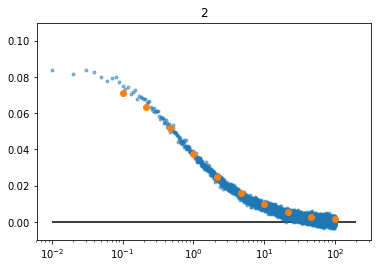

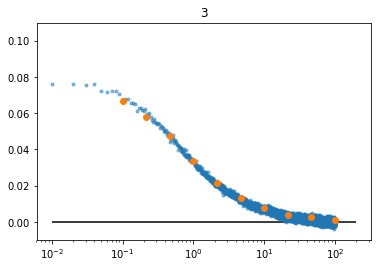

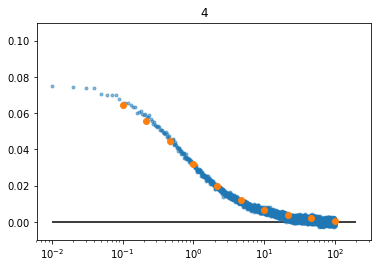

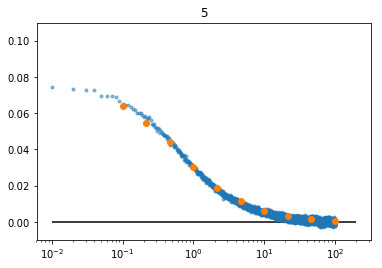

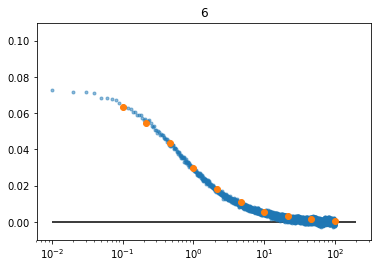

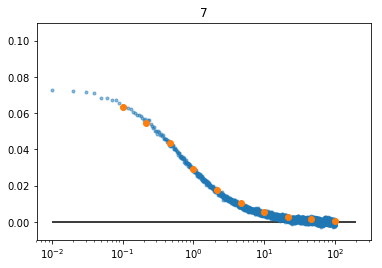

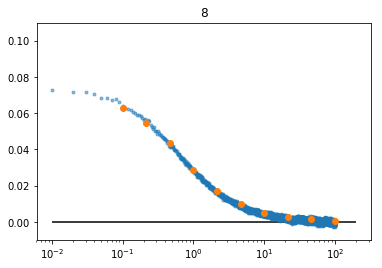

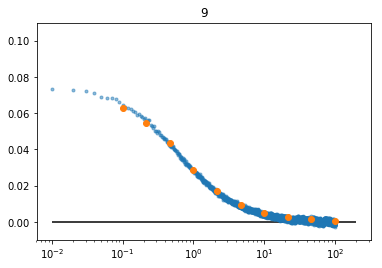

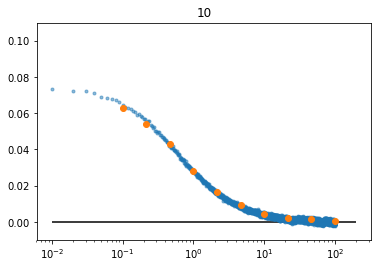

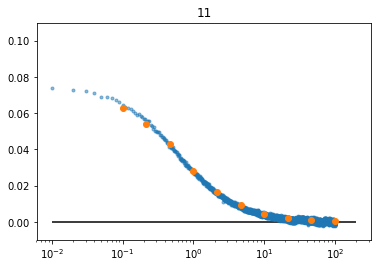

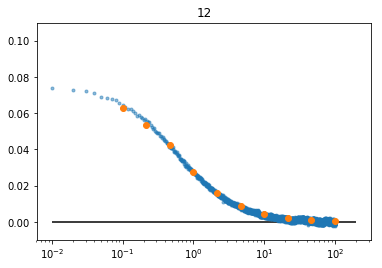

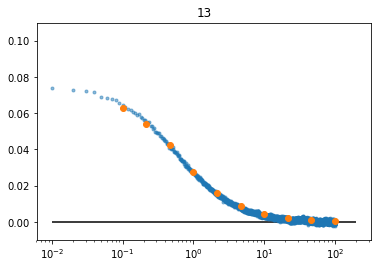

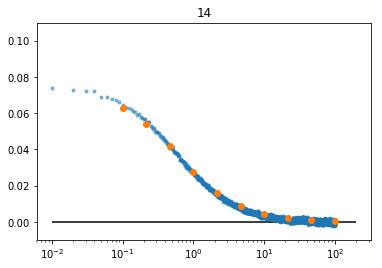

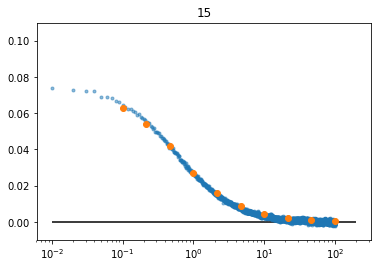

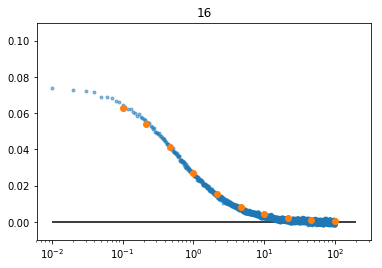

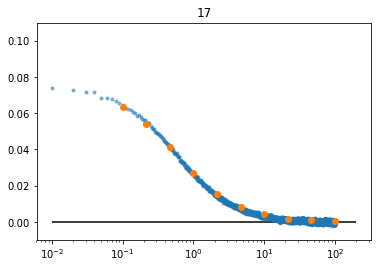

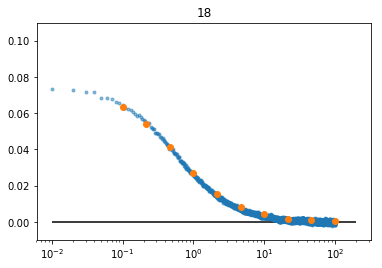

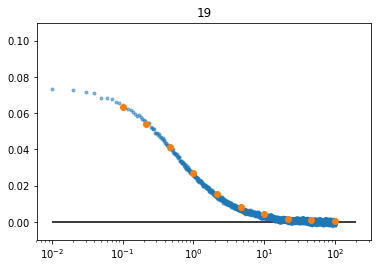

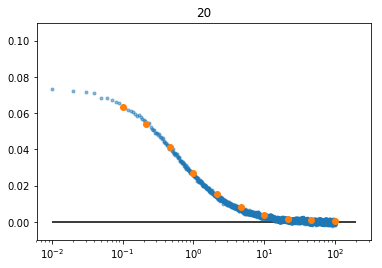

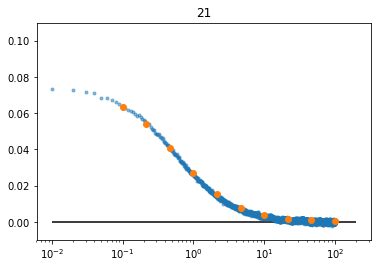

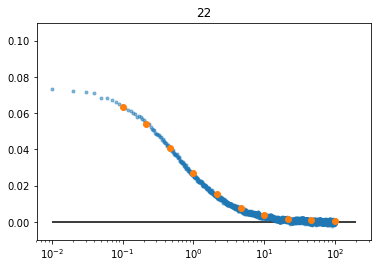

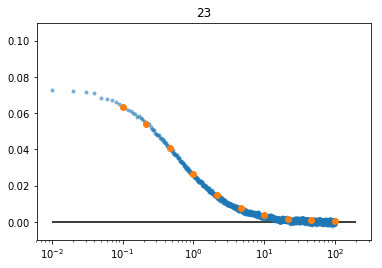

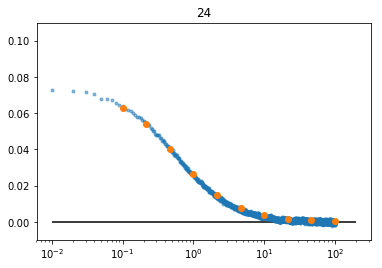

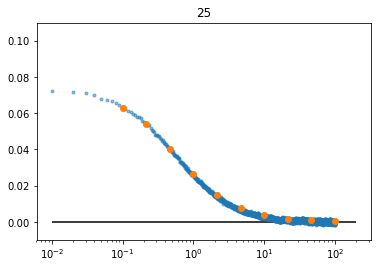

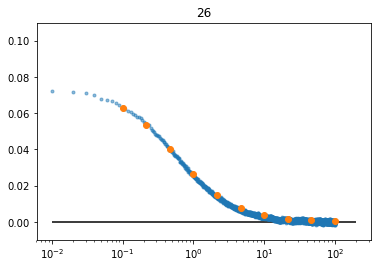

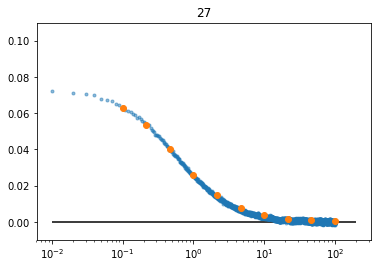

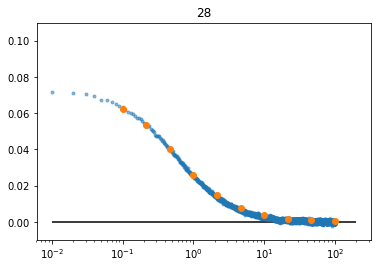

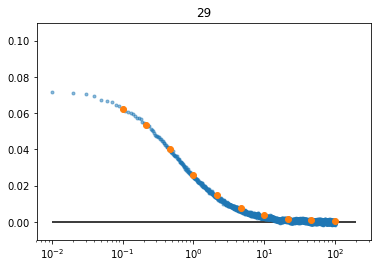

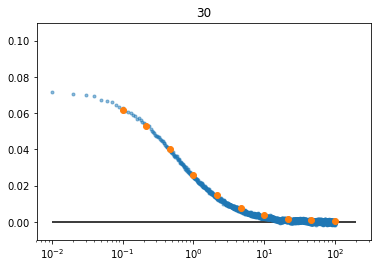

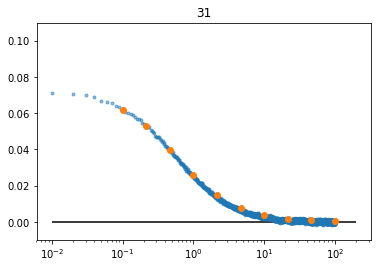

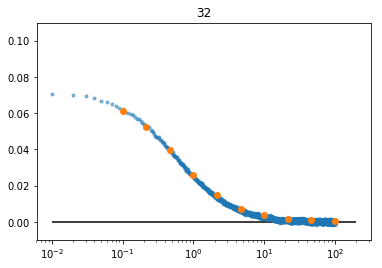

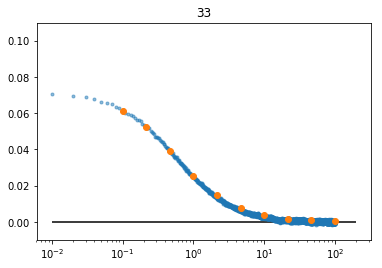

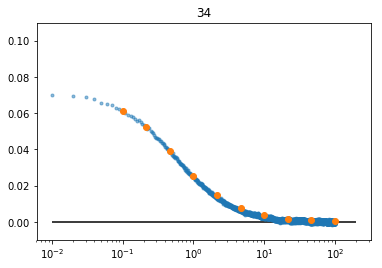

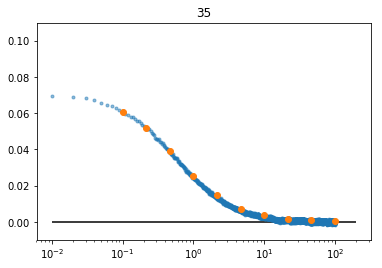

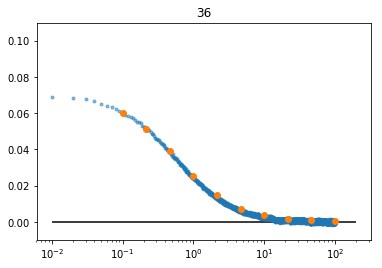

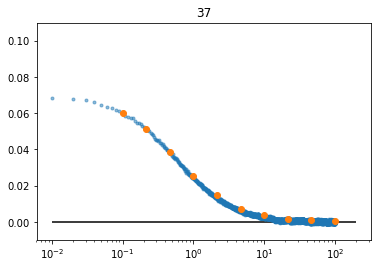

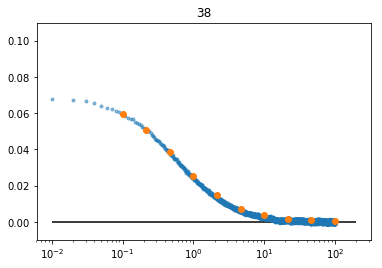

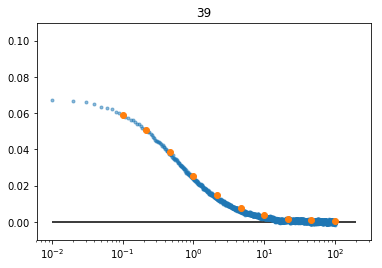

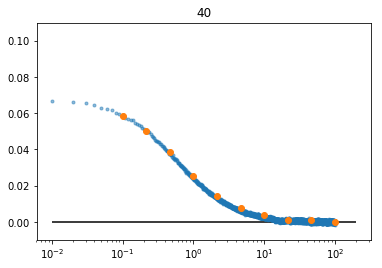

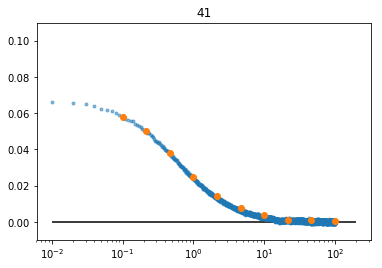

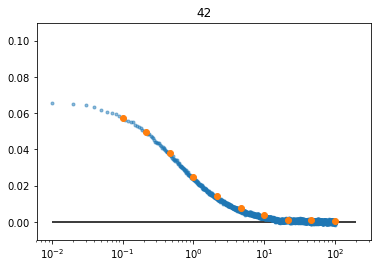

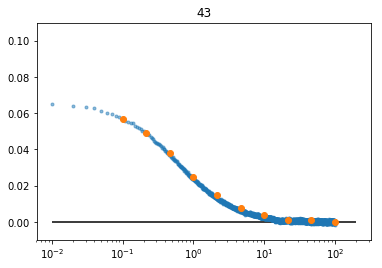

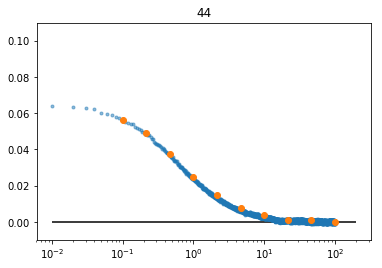

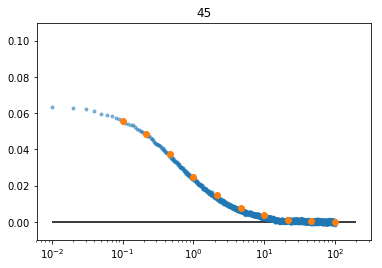

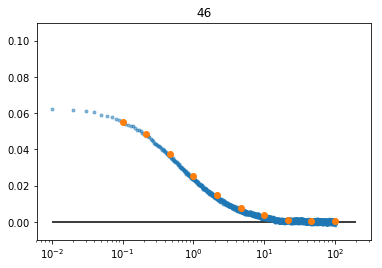

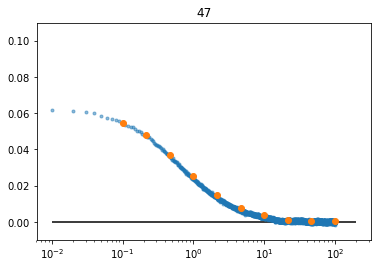

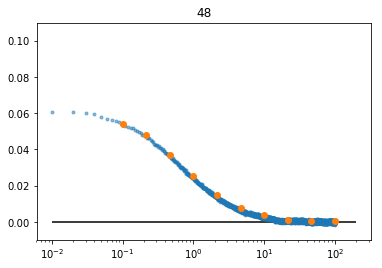

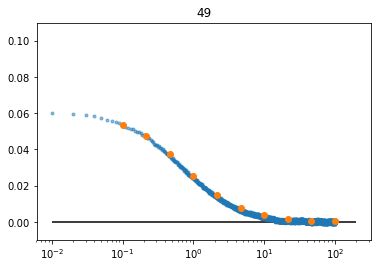

In [11]:
for cutoff in range(1,n_samples//2):
    i = cutoff - 1
    plt.semilogx(dist/d_c, lolo_corr_slim[i], '.', alpha=0.5)
    plt.semilogx(r_list*pi_mspr/2, lolo_corr_mspr[:,i], 'o')
    plt.hlines(0, 1e-2, 2e2)
    plt.ylim([-0.01,0.11])
    plt.title(cutoff)
    plt.show()

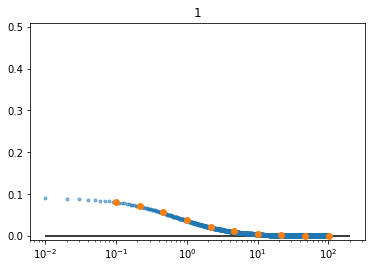

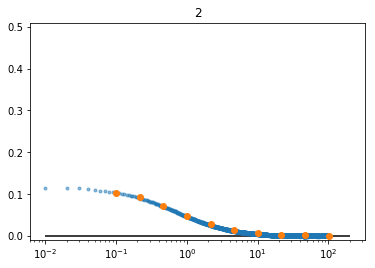

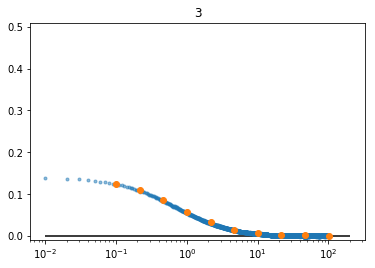

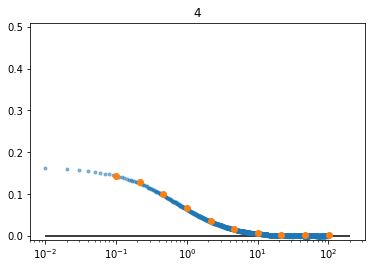

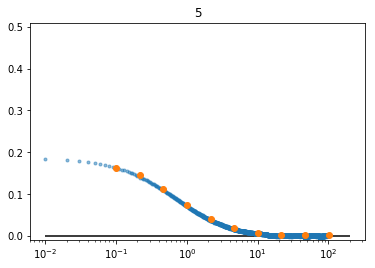

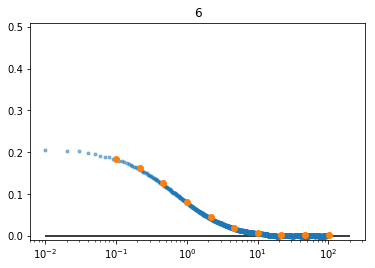

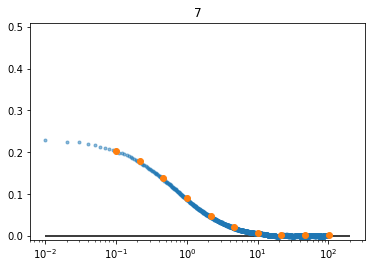

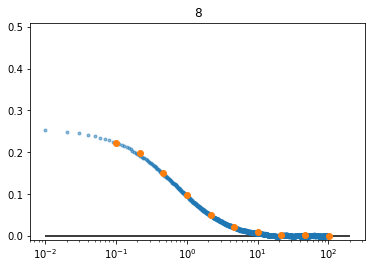

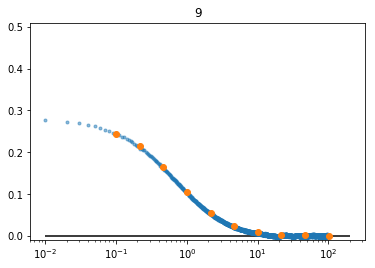

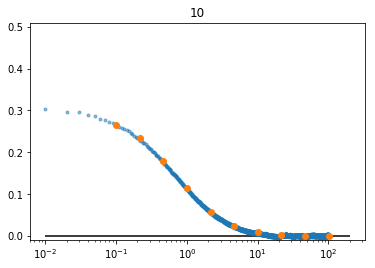

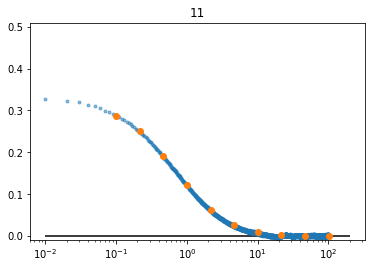

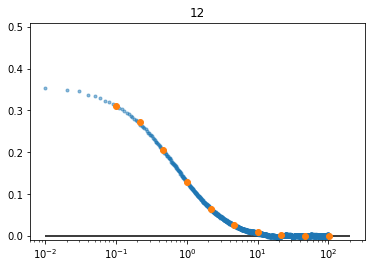

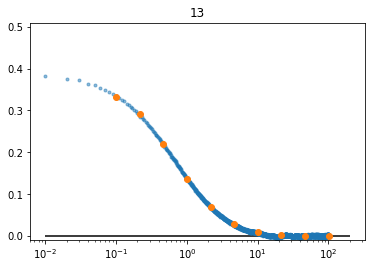

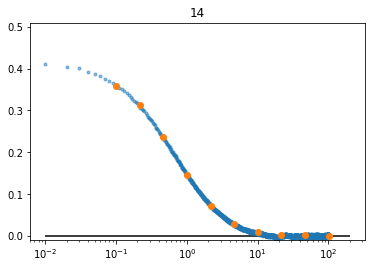

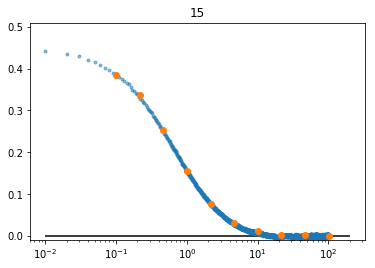

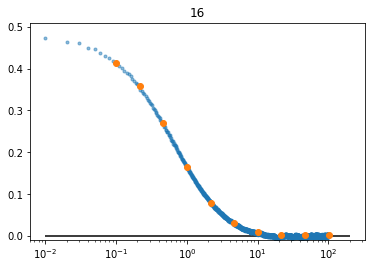

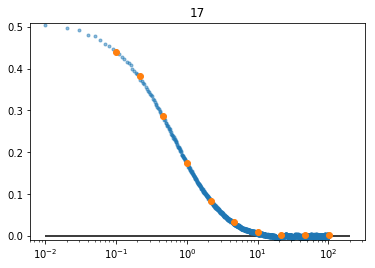

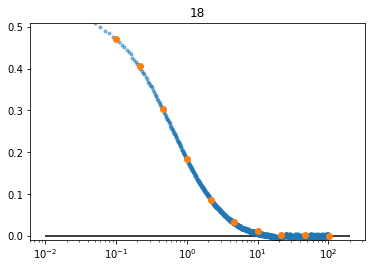

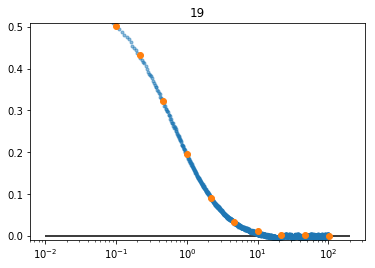

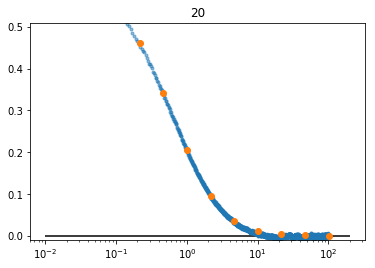

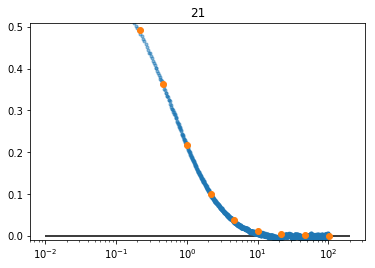

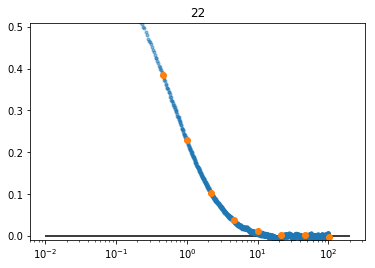

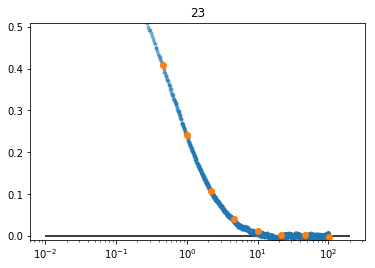

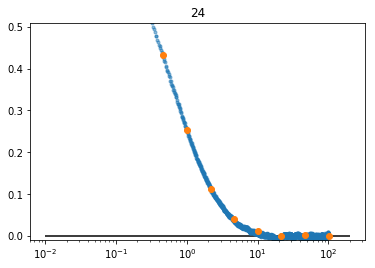

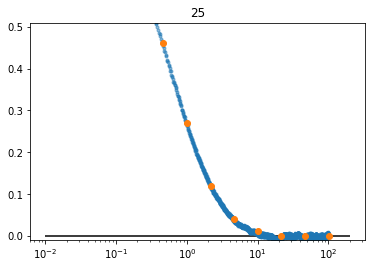

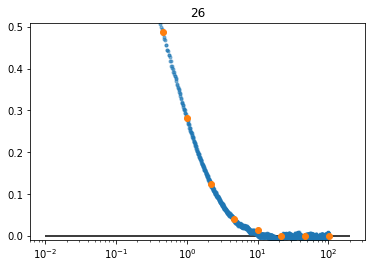

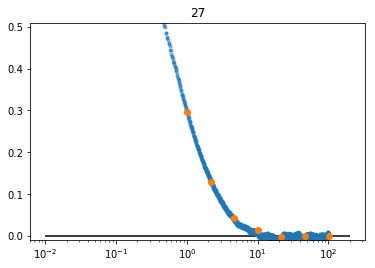

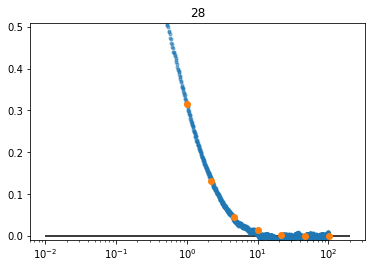

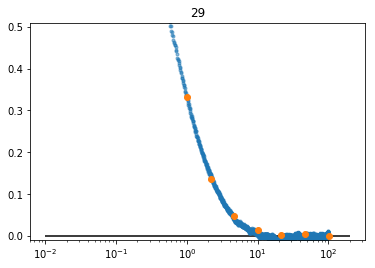

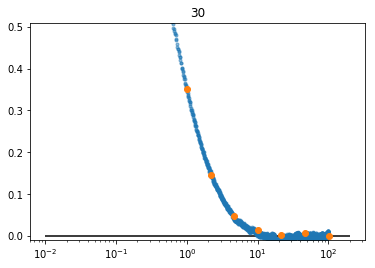

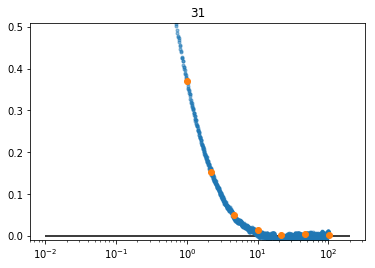

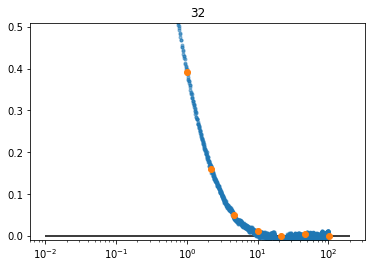

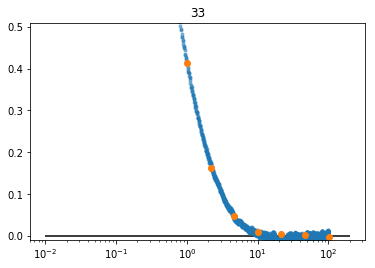

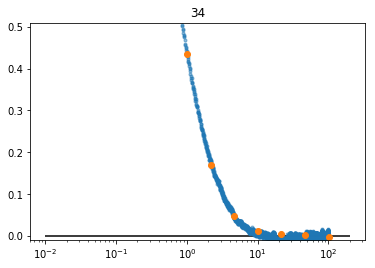

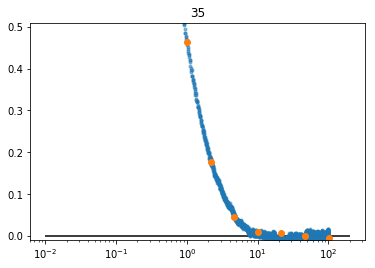

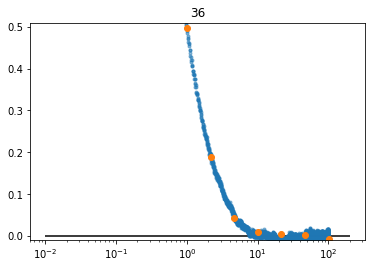

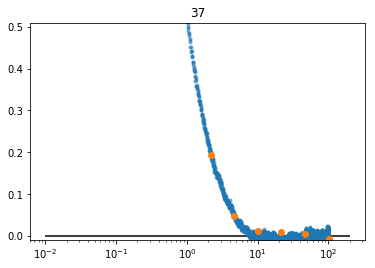

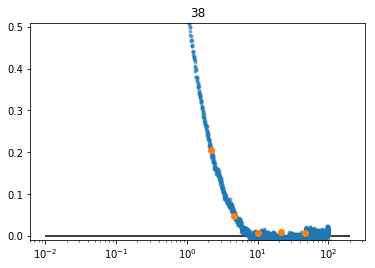

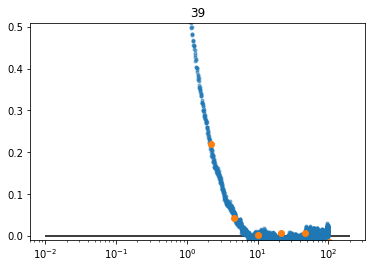

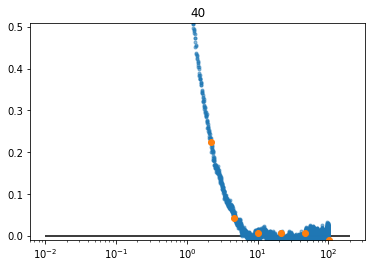

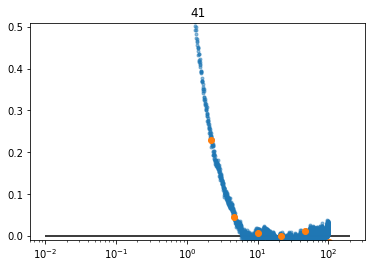

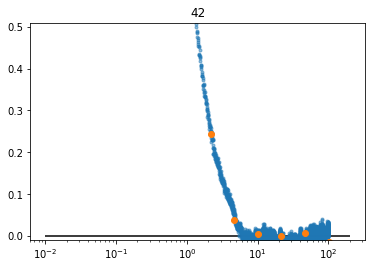

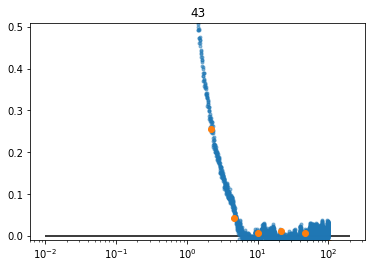

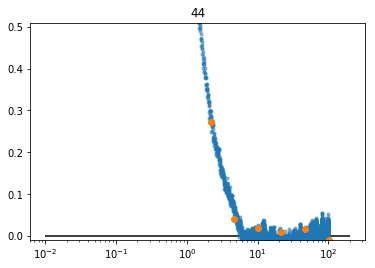

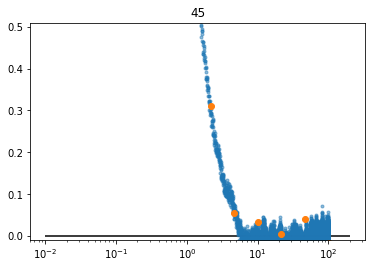

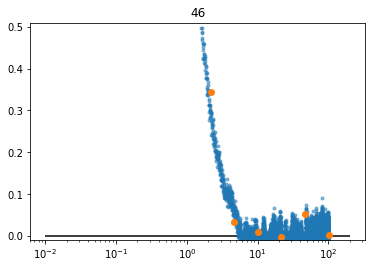

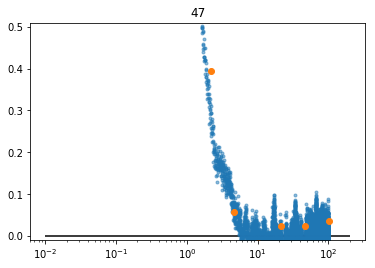

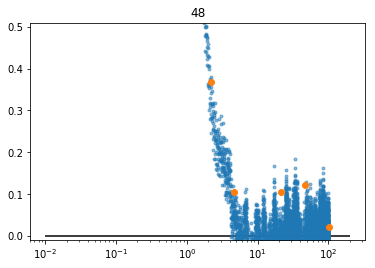

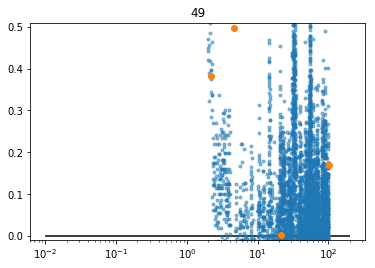

In [12]:
for cutoff in range(1,n_samples//2):
    i = cutoff - 1
    plt.semilogx(dist/d_c, hihi_corr_slim[i], '.', alpha=0.5)
    plt.semilogx(r_list*pi_mspr/2, hihi_corr_mspr[:,i], 'o')
    plt.hlines(0, 1e-2, 2e2)
    plt.ylim([-0.01,0.51])
    plt.title(cutoff)
    plt.show()

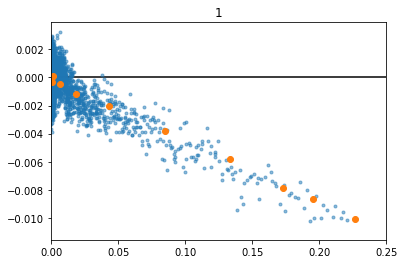

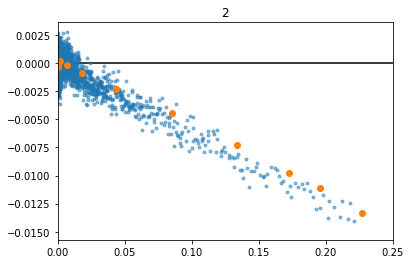

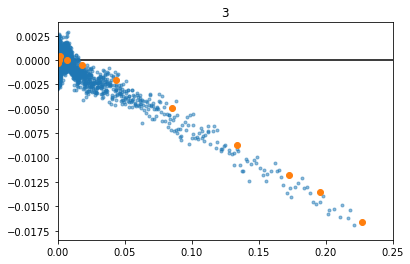

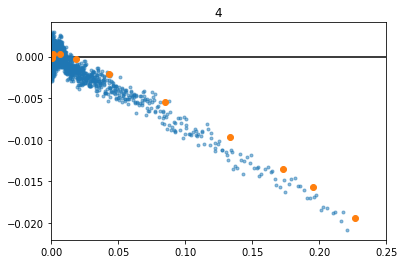

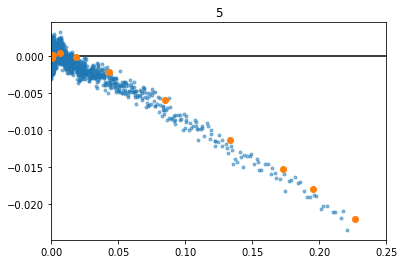

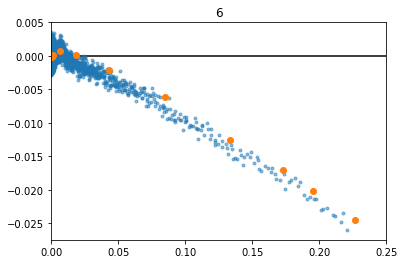

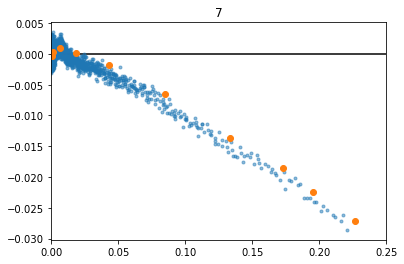

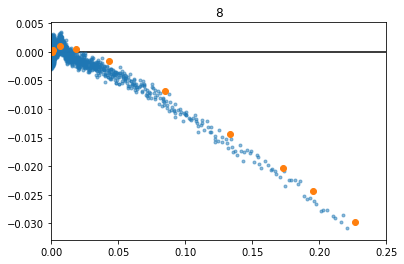

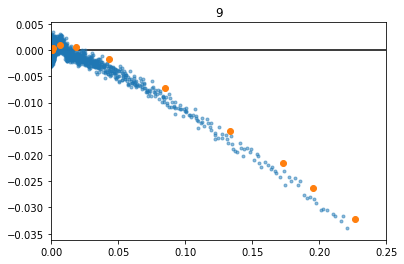

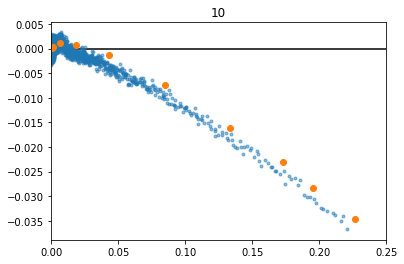

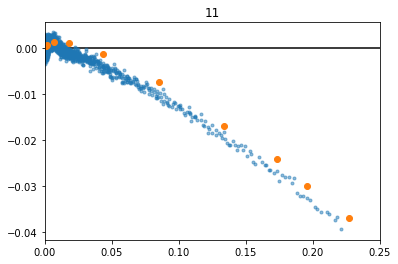

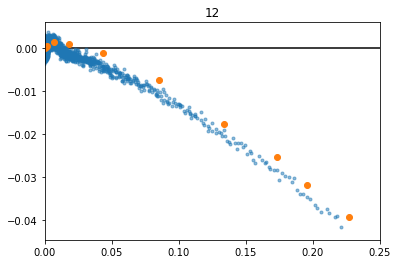

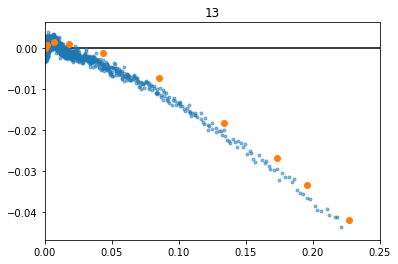

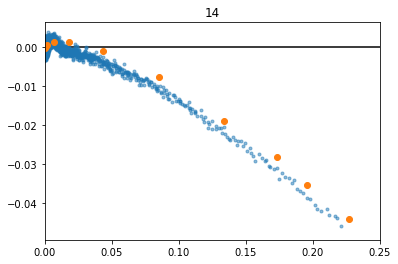

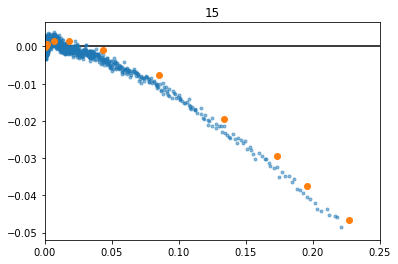

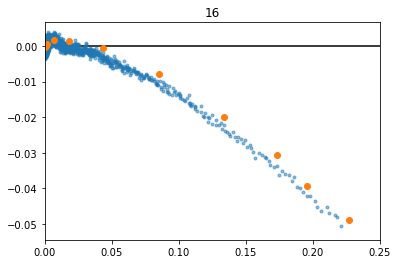

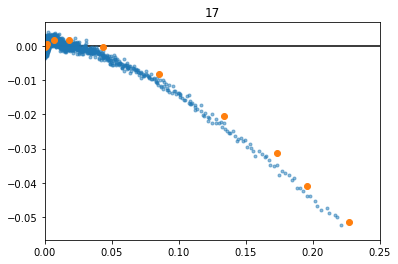

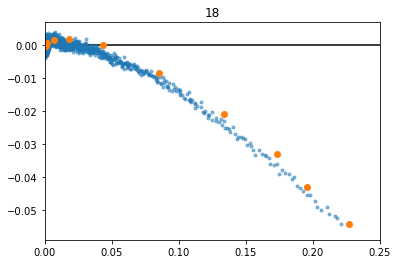

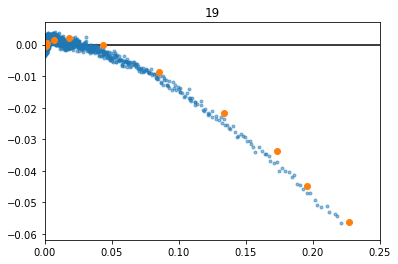

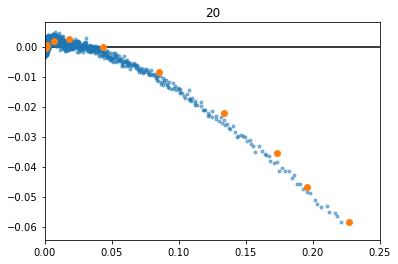

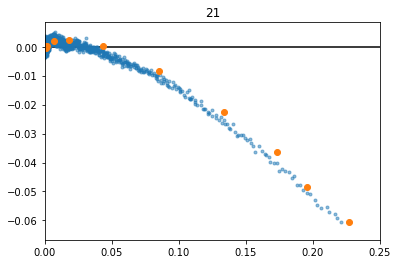

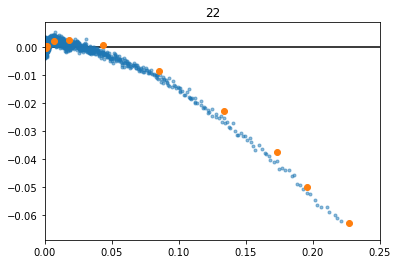

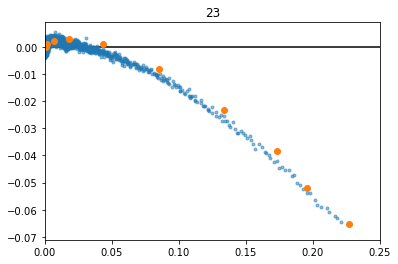

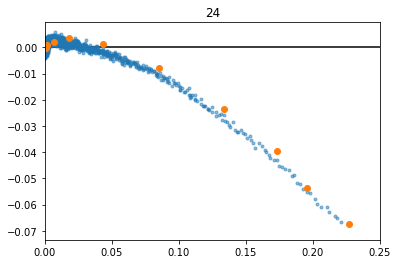

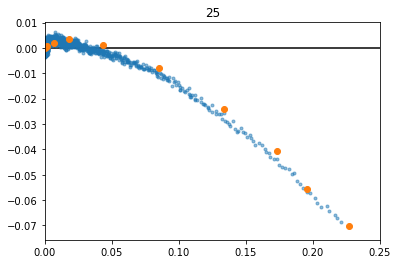

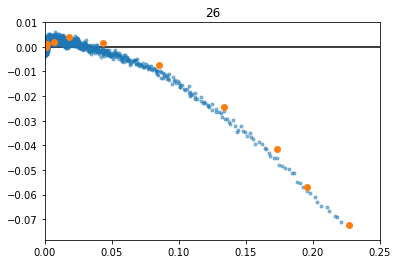

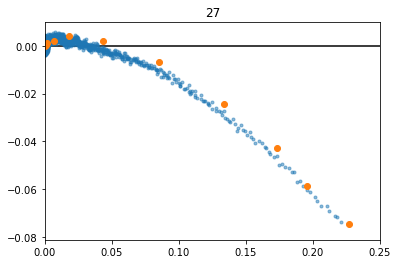

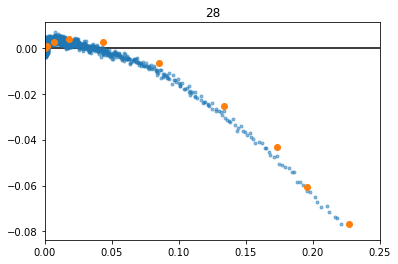

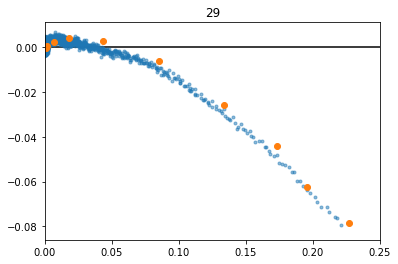

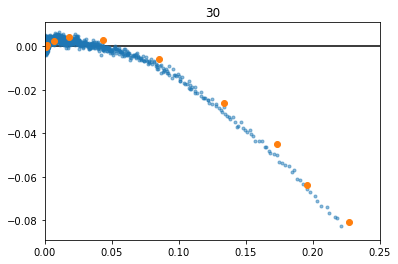

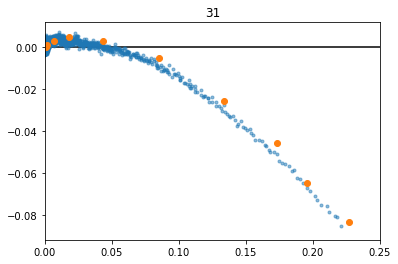

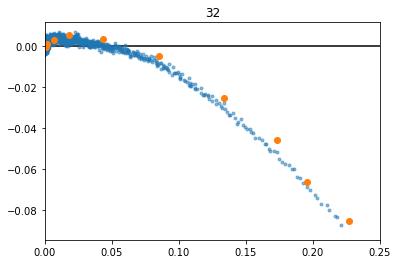

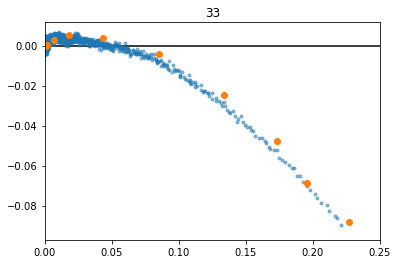

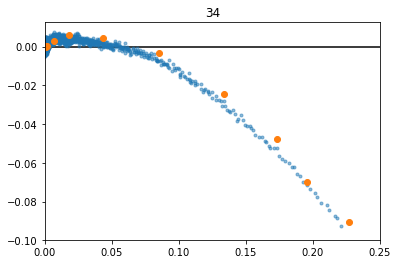

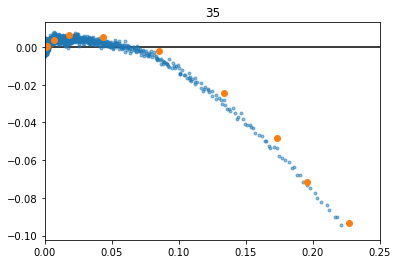

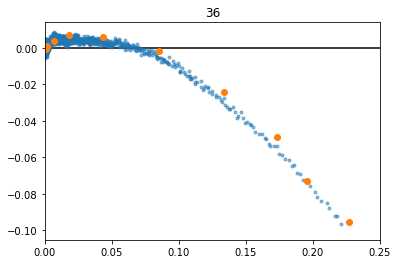

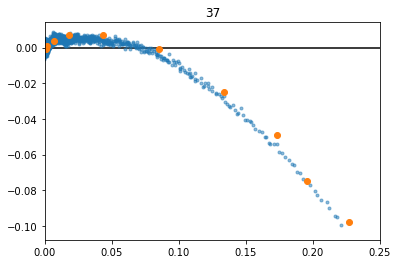

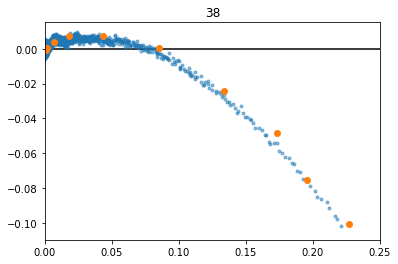

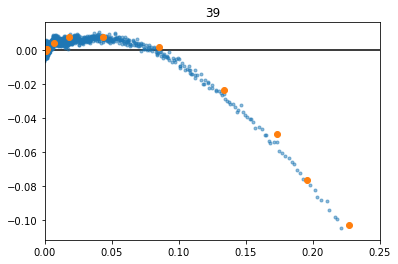

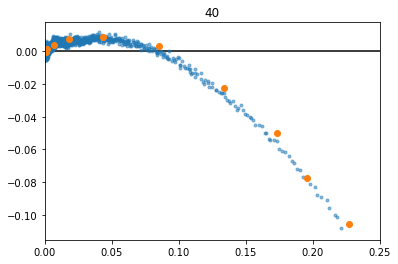

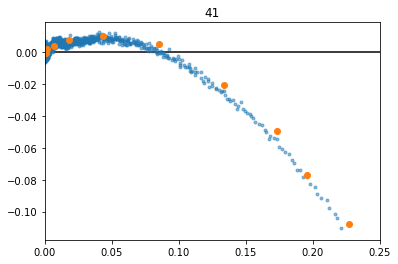

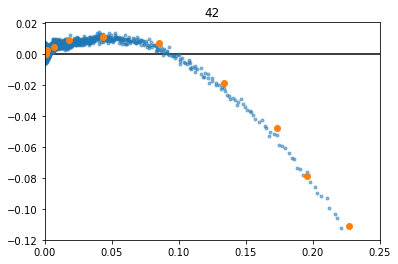

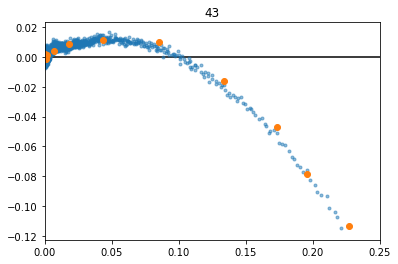

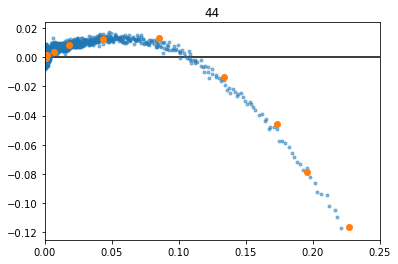

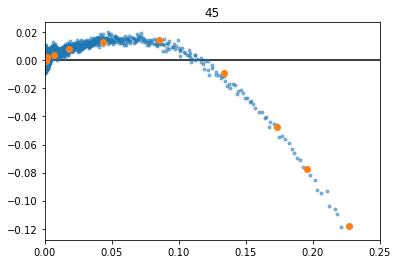

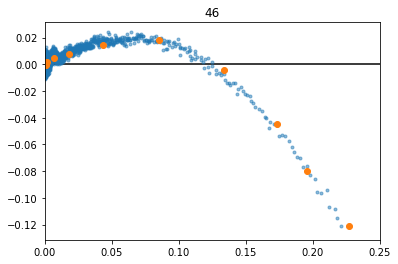

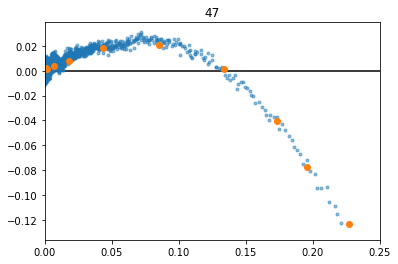

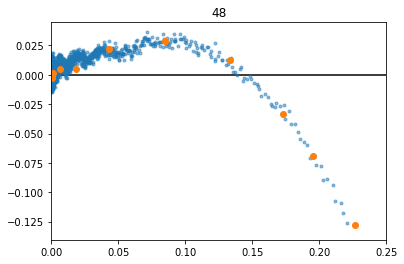

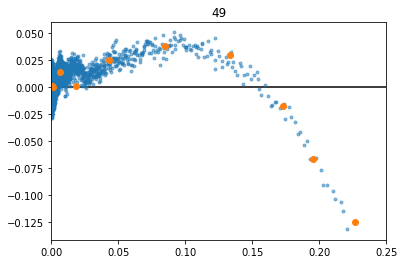

In [13]:
for cutoff in range(1,n_samples//2):
    i = cutoff - 1
    plt.plot(pi_corr_slim, lohi_corr_slim[i], '.', alpha=0.5)
    plt.plot(pi_corr_mspr, lohi_corr_mspr[:,i], 'o')
    plt.hlines(0, 0, 0.25)
    plt.xlim([0,0.25])
    #plt.ylim([-0.1,0.1])
    plt.title(cutoff)
    plt.show()

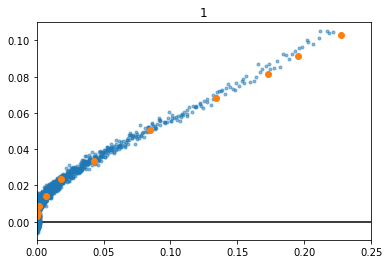

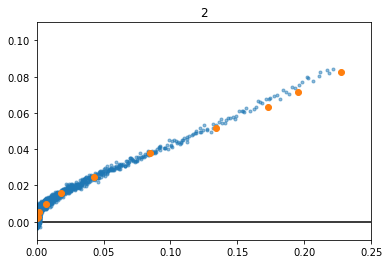

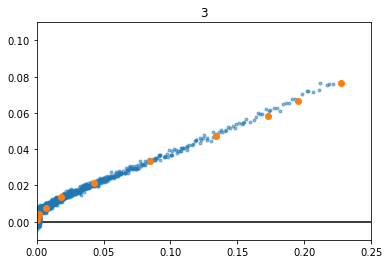

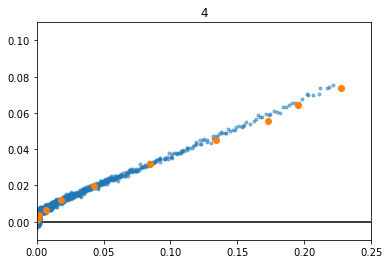

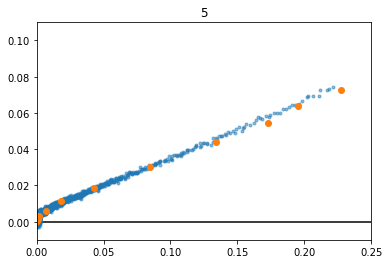

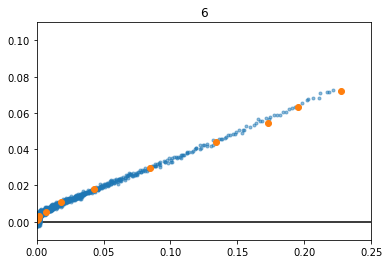

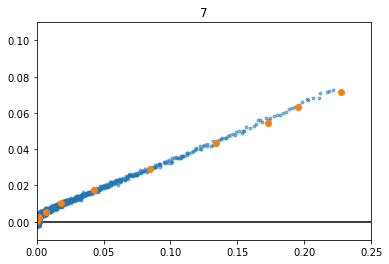

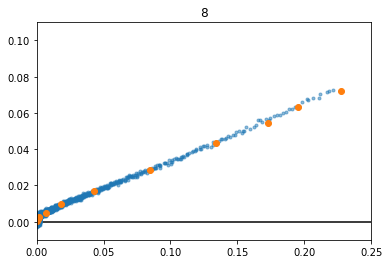

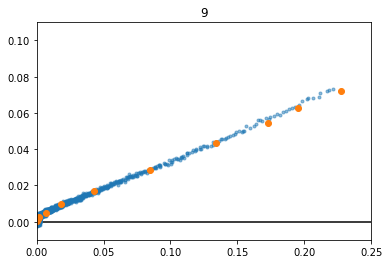

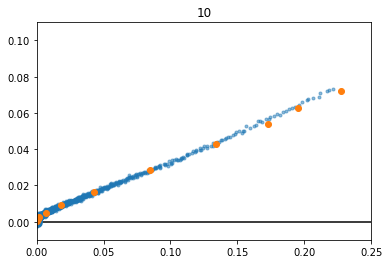

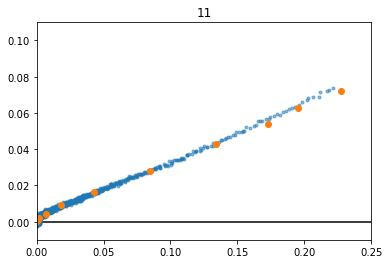

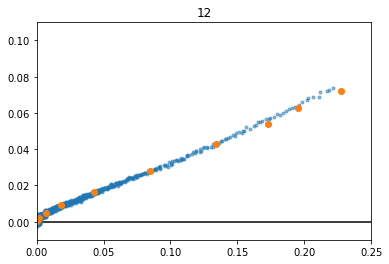

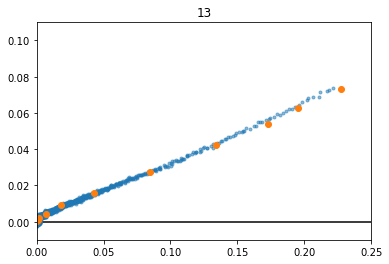

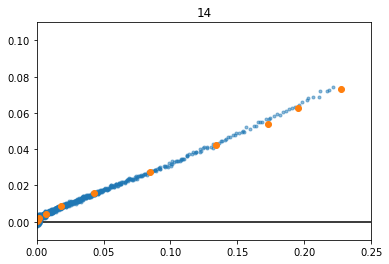

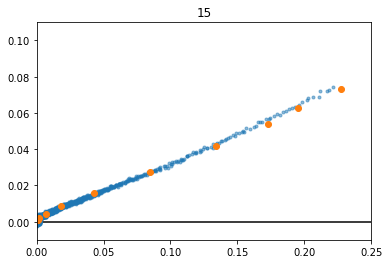

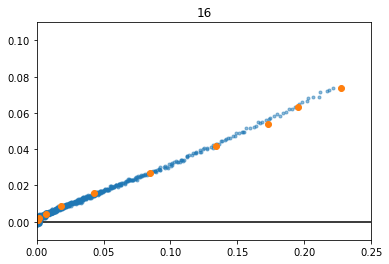

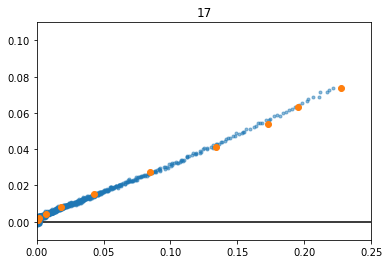

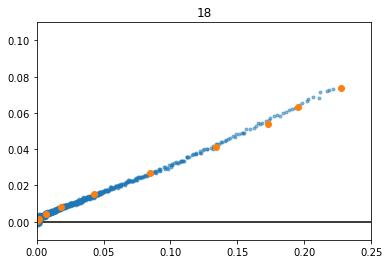

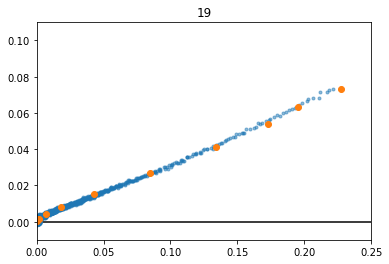

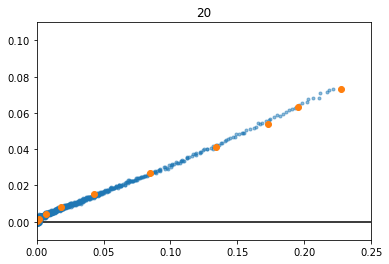

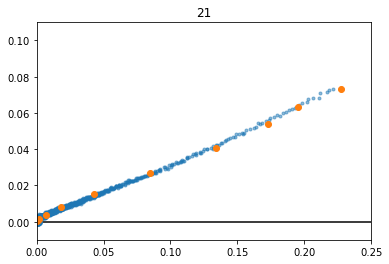

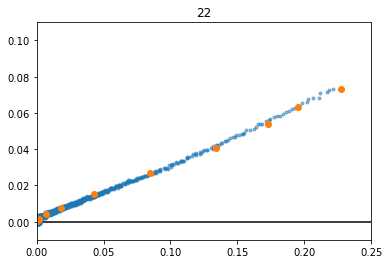

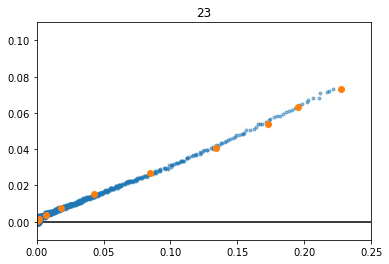

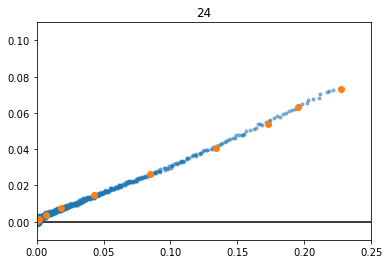

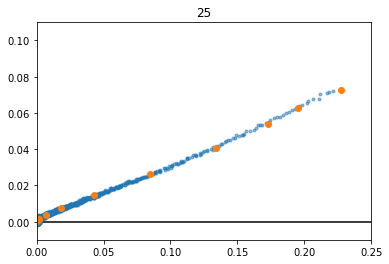

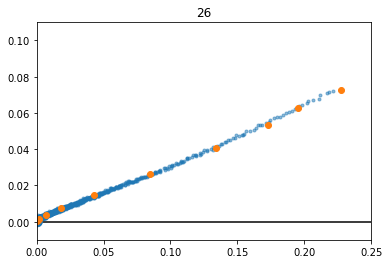

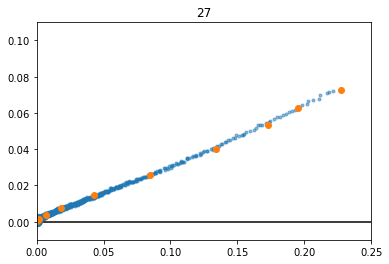

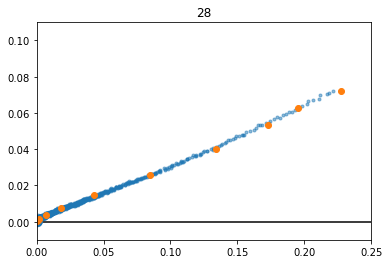

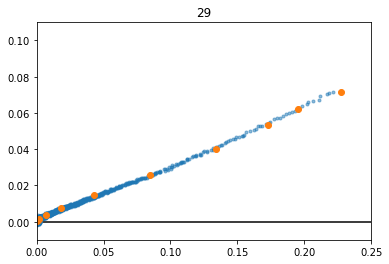

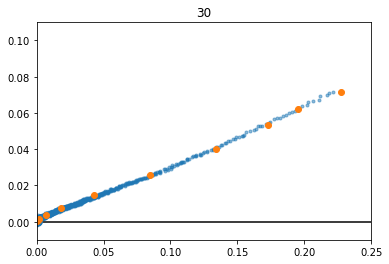

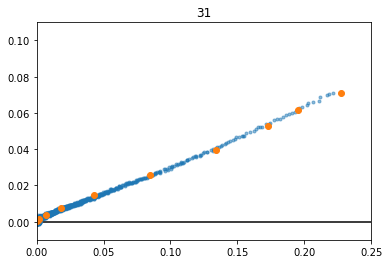

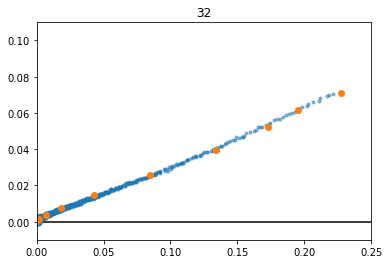

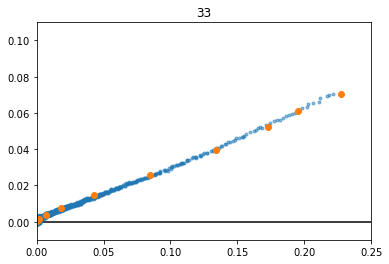

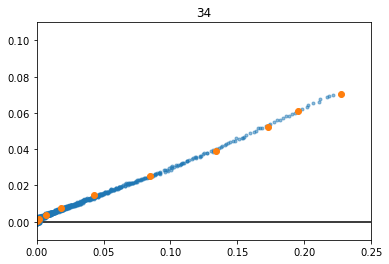

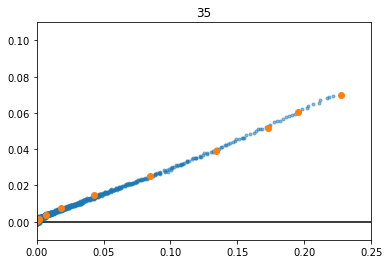

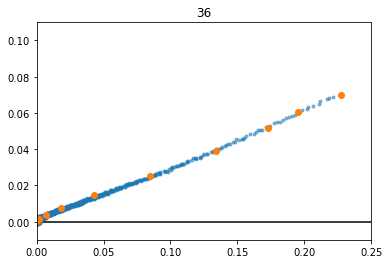

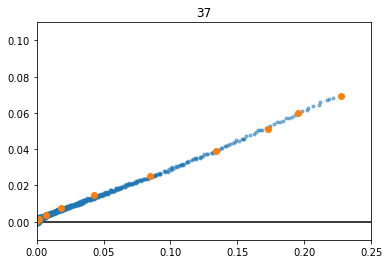

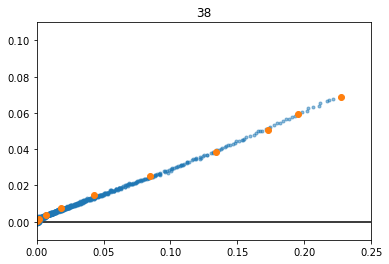

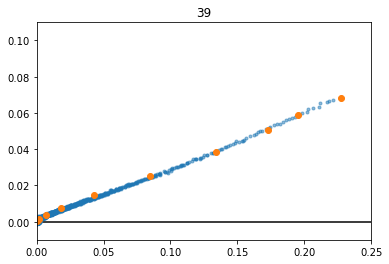

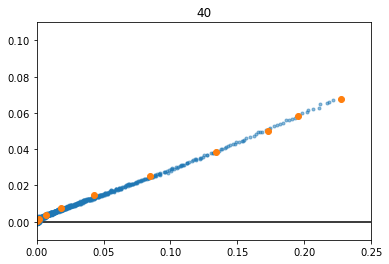

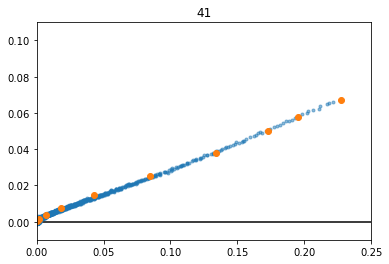

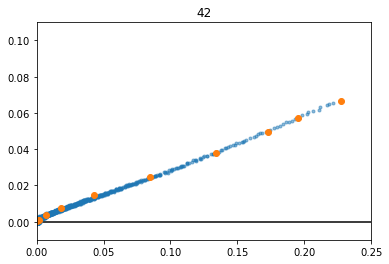

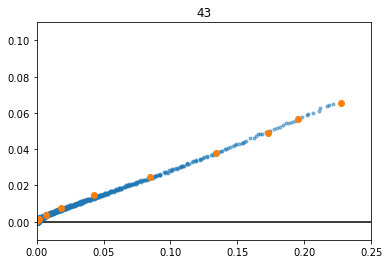

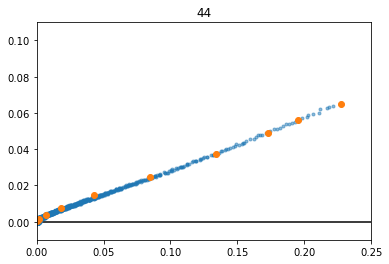

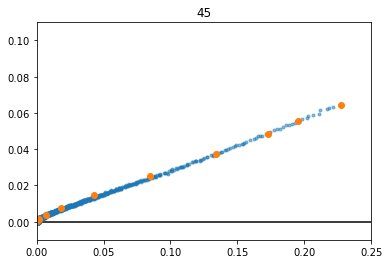

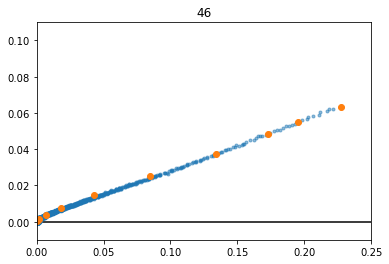

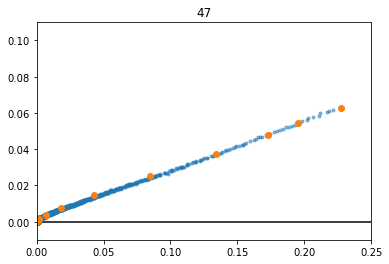

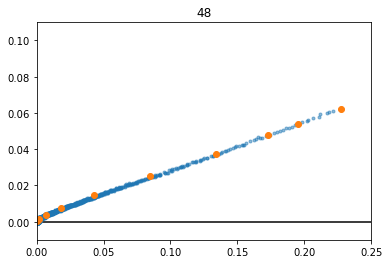

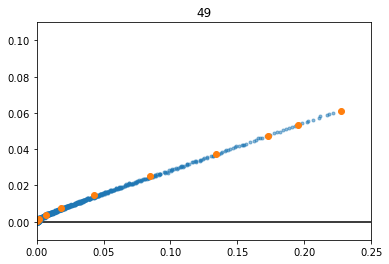

In [14]:
for cutoff in range(1,n_samples//2):
    i = cutoff - 1
    plt.plot(pi_corr_slim, lolo_corr_slim[i], '.', alpha=0.5)
    plt.plot(pi_corr_mspr, lolo_corr_mspr[:,i], 'o')
    plt.hlines(0, 0, 0.25)
    plt.xlim([0,0.25])
    plt.ylim([-0.01,0.11])
    #plt.ylim([-0.1,0.1])
    plt.title(cutoff)
    plt.show()

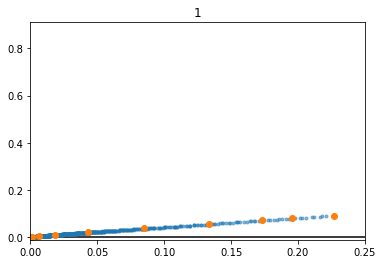

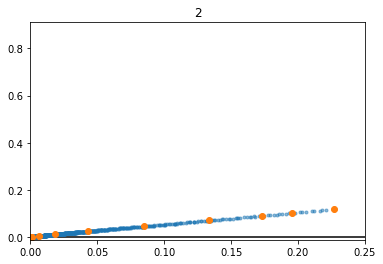

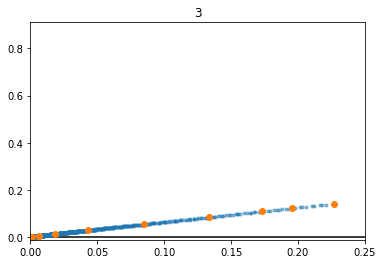

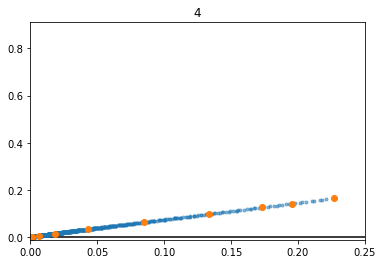

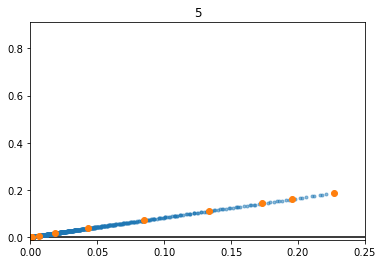

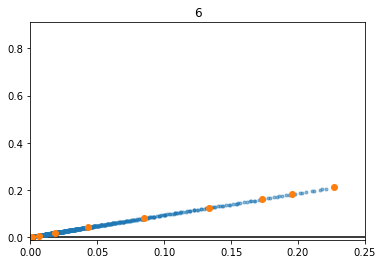

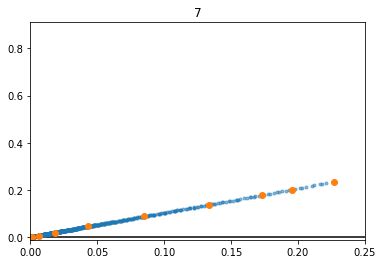

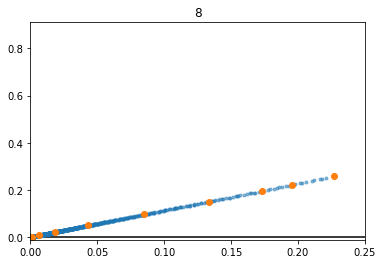

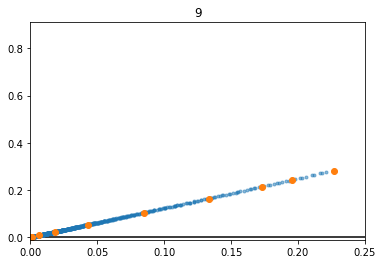

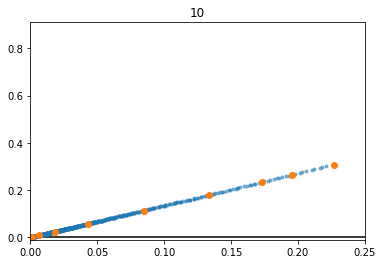

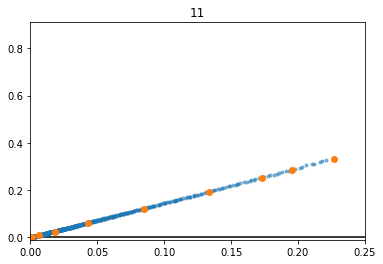

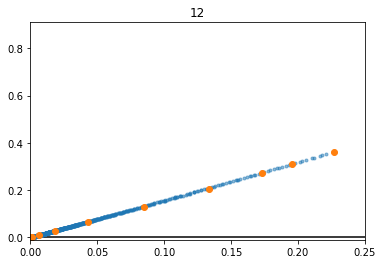

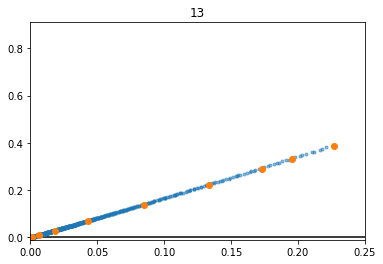

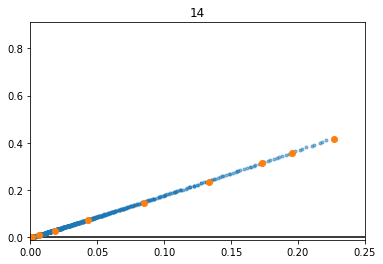

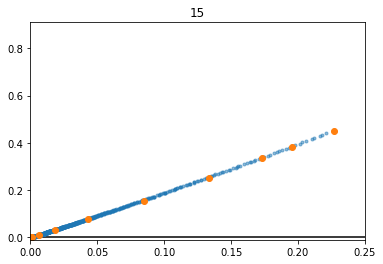

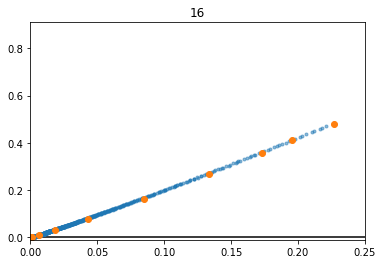

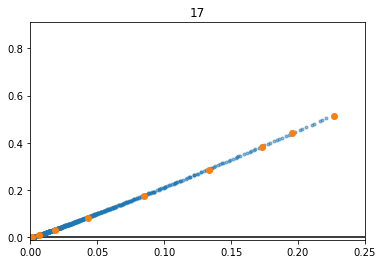

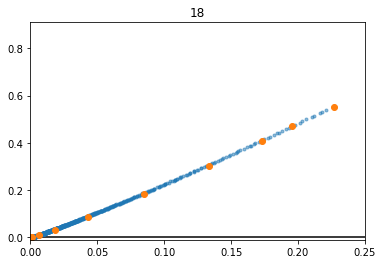

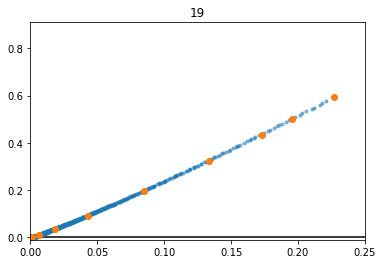

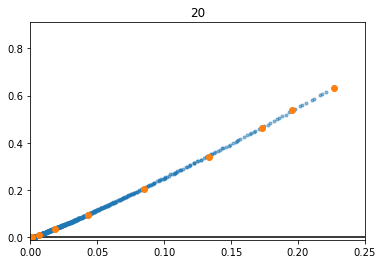

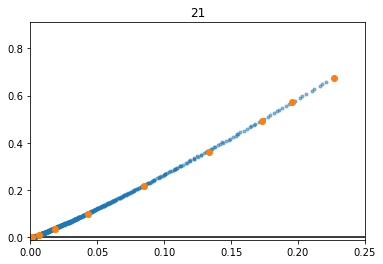

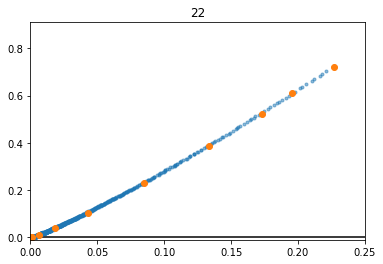

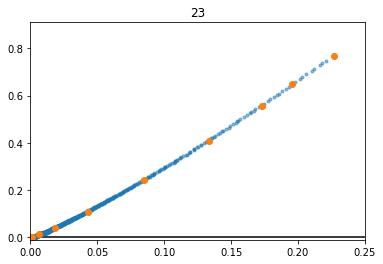

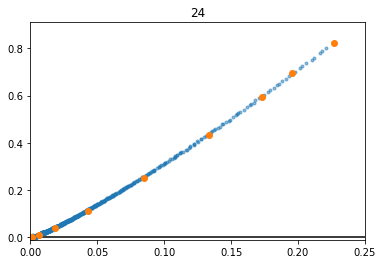

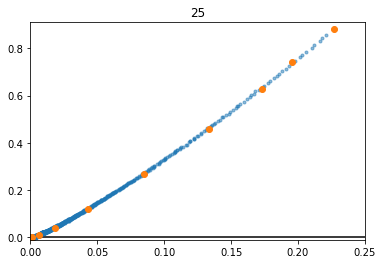

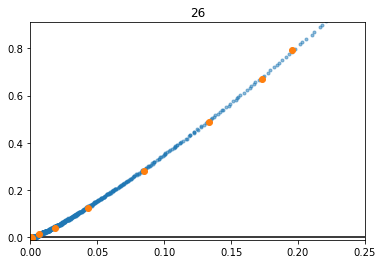

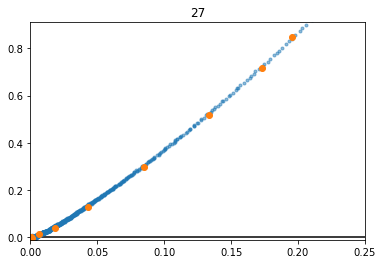

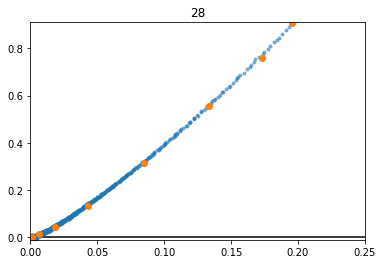

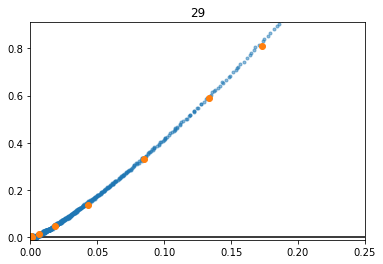

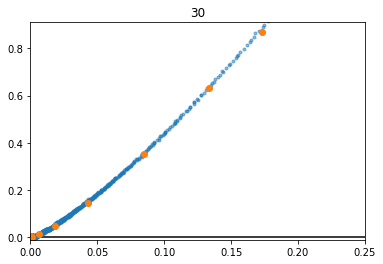

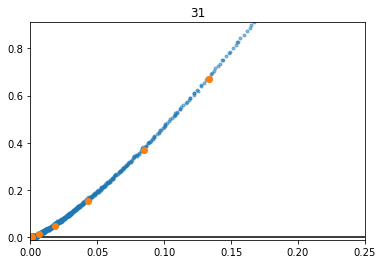

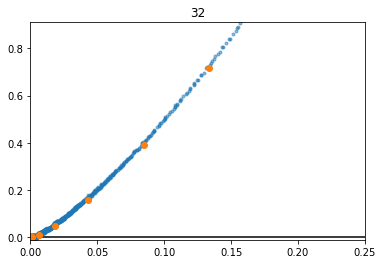

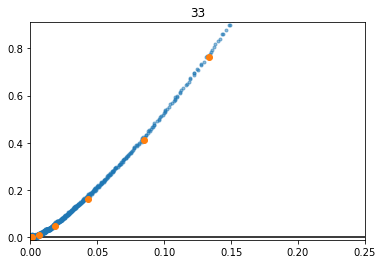

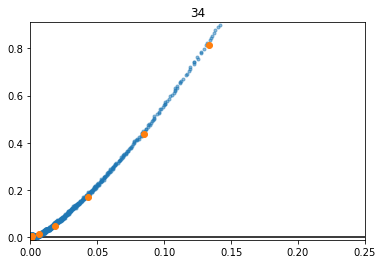

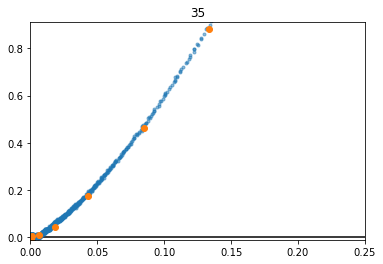

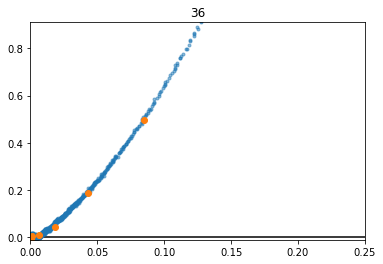

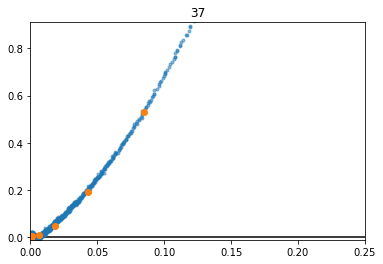

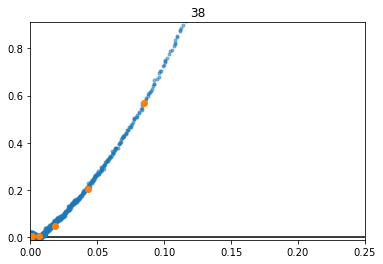

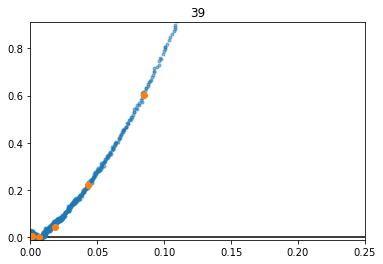

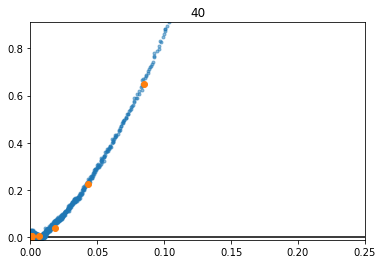

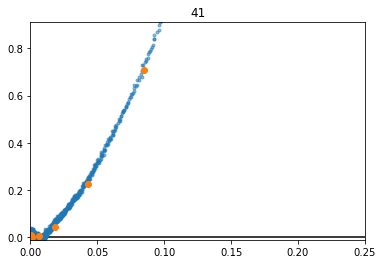

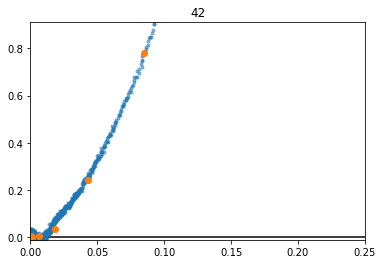

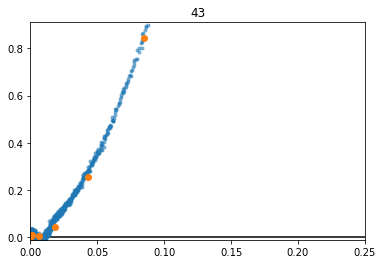

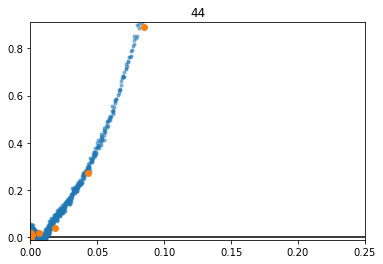

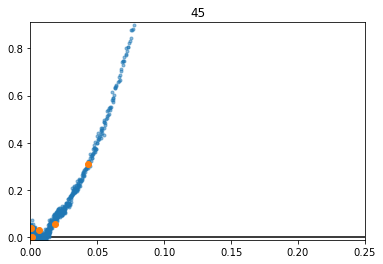

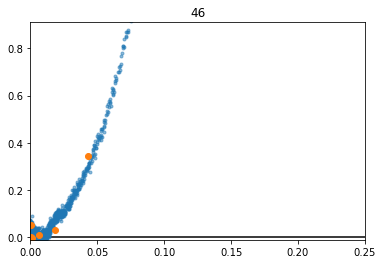

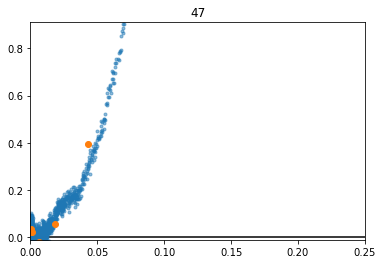

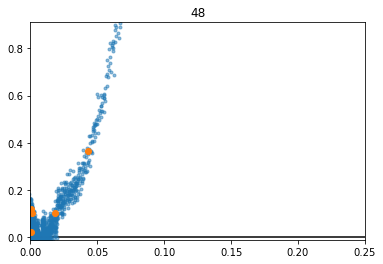

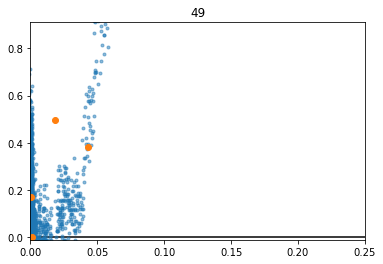

In [15]:
for cutoff in range(1,n_samples//2):
    i = cutoff - 1
    plt.plot(pi_corr_slim, hihi_corr_slim[i], '.', alpha=0.5)
    plt.plot(pi_corr_mspr, hihi_corr_mspr[:,i], 'o')
    plt.hlines(0, 0, 0.25)
    plt.xlim([0,0.25])
    plt.ylim([-0.01,0.91])
    #plt.ylim([-0.1,0.1])
    plt.title(cutoff)
    plt.show()